# T-Maze Task with Distractors

In this tutorial, we set up a T-maze task where an agent navigates a grid to locate rewards. The agent can move in four directions: up, down, left, or right. 

The agent would navigate to the cues to obtain information about two potential reward locations. While these cues guide the agent's search, they do not guarantee the presence of a real reward. The agent must learn that some cues are distractors, so it may follow them initially but should recognize when a location does not contain a real reward and continue exploring.

This is to test sophisticated inference. 


## Initial Setup
To run this notebook, it's recommended to use a virtual environment. You can refer to [this guide](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/) to learn how to set up a virtual environment.

Then, install the current repo as a package in editable mode by running the following command in your terminal:
```bash
pip install -e .
```

And then, install mediapy by running the following command in your terminal:
```bash
pip install mediapy
```

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import jax.numpy as jnp
import jax.tree_util as jtu
import mctx
from jax import random as jr


from pymdp.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, parse_maze, get_maze_matrix, render 
)

from pymdp.envs.rollout import rollout
from pymdp.agent import Agent as AIFAgent
from pymdp.planning.mcts import mcts_policy_search

from copy import copy

key = jr.PRNGKey(0)


## Creating the Environment

The environment consists of the following elements, which are represented in the figure:

- **Agent (Green Square)**: The agent starts at a designated position and explores the grid to locate rewards.
- **Cues and Reward Sets**: Each colour represents a set that includes one cue (marked by a black cross) and two potential reward locations associated with that cue.
  - **Green Set (True Reward Set)**: Contains real outcomes. Each reward location has a secondary dot to indicate the type of outcome:
    - **Red Dot**: Indicates a reward.
    - **Blue Dot**: Indicates a punishment.
  - **Orange and Blue Sets (Distractor Sets)**: These are distractor sets that do not contain real rewards. The reward locations in these sets lack a secondary dot, indicating a false reward location. Although the cues point to these locations, they do not contain actual rewards.


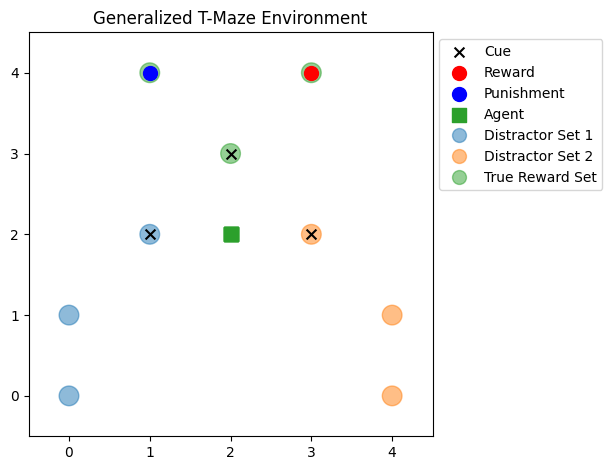

In [15]:
M = get_maze_matrix()
key, subkey = jr.split(key)
env_info_m = parse_maze(M, subkey)
batch_size = 5

# we simulate 5 agents in parallel
tmaze_env = GeneralizedTMazeEnv(env_info_m, batch_size=batch_size)

keys = jr.split(key, num=batch_size + 1)
key = keys[0]
obs, env = tmaze_env.reset(keys[1:])
_ = render(env_info_m, env)

## Creating the Agent

State Factors: 
- Position: however large the grid is
- Reward: location of the reward

Observation Modalities:
- Position: however large the grid is
- Cued info: null, first location, second location
- Reward: null, no reward, reward

The PyMDPEnv class consists of a params dict that contains the A, B, and D vectors of the environment. We initialize our agent using the same parameters. This means that the agent has full knowledge about the environment transitions, and likelihoods. We initialize the agent with a flat prior, i.e. it does not know where it, or the reward is. Finally, we set the C vector to have a preference only over the rewarding observation of cue-reward pair 1 (i.e. C[1][1] = 1 and zero for other values). 

In [16]:
A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

# [position], [cue], [reward]
C = [jnp.zeros(a.shape[:2]) for a in A]

rewarding_modality = -1

C[rewarding_modality] = C[rewarding_modality].at[:, 1].set(1.0)
C[rewarding_modality] = C[rewarding_modality].at[:, 2].set(-2.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

batch_size = A[0].shape[0]


agent = AIFAgent(
    A, B, C, D, 
    E=None,
    pA=None,
    pB=None,
    policy_len=5,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    use_utility=True,
    use_states_info_gain=True,
    sampling_mode='full',
    batch_size=batch_size,
    learn_A=False,
    learn_B=False
)


In [17]:
print("A tensors")
print(A[0].shape)
print(A[1].shape)
print(A[2].shape)
print(A[3].shape)
print(A[4].shape)
print(A[5].shape)
print(A[6].shape)
print()
print("B tensors")
print(B[0].shape)
print(B[1].shape)
print(B[2].shape)
print(B[3].shape)
print()
print("C tensors")
print(C[0].shape)
print(C[1].shape)
print(C[2].shape)
print(C[3].shape)
print(C[4].shape)
print(C[5].shape)
print(C[6].shape)
print()
print("D tensors")
print(D[0].shape)
print(D[1].shape)
print(D[2].shape)
print(D[3].shape)
print()
print("A and B dependencies")
print(A_dependencies)
print(B_dependencies)


A tensors
(5, 25, 25)
(5, 3, 25, 2)
(5, 3, 25, 2)
(5, 3, 25, 2)
(5, 3, 25, 2)
(5, 3, 25, 2)
(5, 3, 25, 2)

B tensors
(5, 25, 25, 5)
(5, 2, 2, 1)
(5, 2, 2, 1)
(5, 2, 2, 1)

C tensors
(5, 25)
(5, 3)
(5, 3)
(5, 3)
(5, 3)
(5, 3)
(5, 3)

D tensors
(5, 25)
(5, 2)
(5, 2)
(5, 2)

A and B dependencies
[[0], [0, 1], [0, 2], [0, 3], [0, 1], [0, 2], [0, 3]]
[[0], [1], [2], [3]]


### Rollout an agent episode 

Using the rollout function, we can run an active inference agent in this environment over a specified number of discrete timesteps using the parameters previously set. 

In [18]:
key = jr.PRNGKey(0)
T = 5
_, info, _ = rollout(agent, tmaze_env, num_timesteps=T, rng_key=key)

In [19]:
images = []
for t in range(T):
    env_state = copy(info['env'])
    env_state.state = jtu.tree_map(lambda x: x[:, t], info['env'].state)
    images.append(np.array(render(env_info_m, env_state, show_img=False)) )

In [20]:
# make animation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

def animate(images, savefile=None):
    fig, ax = plt.subplots()

    sns.despine(fig, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    frames = []
    for i, img in enumerate(images):
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        frames.append([im])

    ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                    repeat_delay=1000)

    # To save the animation, use e.g.
    if savefile is not None:
        ani.save(savefile)

    plt.close(ani._fig)

    return ani

ani = animate(images)
HTML(ani.to_html5_video())